<a href="https://colab.research.google.com/github/Sutapa94/delivery-spending-predictor/blob/main/Sutapa_Banerjee_GIAP_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CAPSTONE: Impact of 10-Minute Delivery Apps**
## **Goal: Predict Spending Patterns & Analyze Failures**


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

In [26]:
# Set professional aesthetics
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [27]:
# 1. DATA GENERATION
np.random.seed(42)
n = 2000

data = {
    'user_id': range(n),
    'age': np.random.randint(18, 65, n),
    'city_tier': np.random.choice([1, 2, 3], n, p=[0.5, 0.3, 0.2]),
    'monthly_income_usd': np.random.normal(4000, 1200, n),
    'app_opening_freq': np.random.randint(5, 100, n),
    'last_month_orders': np.random.randint(0, 40, n),
    'avg_basket_size': np.random.normal(25, 10, n),
    'is_pro_member': np.random.choice([0, 1], n, p=[0.7, 0.3]),
    'distance_to_dark_store_km': np.random.uniform(0.5, 5, n)
}

df = pd.DataFrame(data)

In [33]:
# FEATURE ENGINEERING: Creating a complex target variable
# Spending is influenced by income, proximity, and membership
df['total_spending'] = (
    (df['last_month_orders'] * df['avg_basket_size']) +
    (df['is_pro_member'] * 75) -
    (df['distance_to_dark_store_km'] * 10) +
    np.random.normal(0, 20, n)
)
df['total_spending'] = df['total_spending'].clip(lower=0)

In [34]:
# 2. STRATEGIC OUTLIER INJECTION (Crucial for Failure Analysis)

# Row 452: The "Bulk Party" (Low frequency, high spend)
df.loc[452, 'total_spending'] = 6500.00
df.loc[452, 'last_month_orders'] = 1

# Row 1029: The "Wealthy Skeptic" (High income, near zero spend)
df.loc[1029, 'monthly_income_usd'] = 9800.00
df.loc[1029, 'total_spending'] = 5.00

# Row 1992: The "Logistics Edge" (Lives far away, model will over-predict)
df.loc[1992, 'distance_to_dark_store_km'] = 4.95
df.loc[1992, 'total_spending'] = 2.00

df['total_spending'] = df['total_spending'].clip(lower=0)

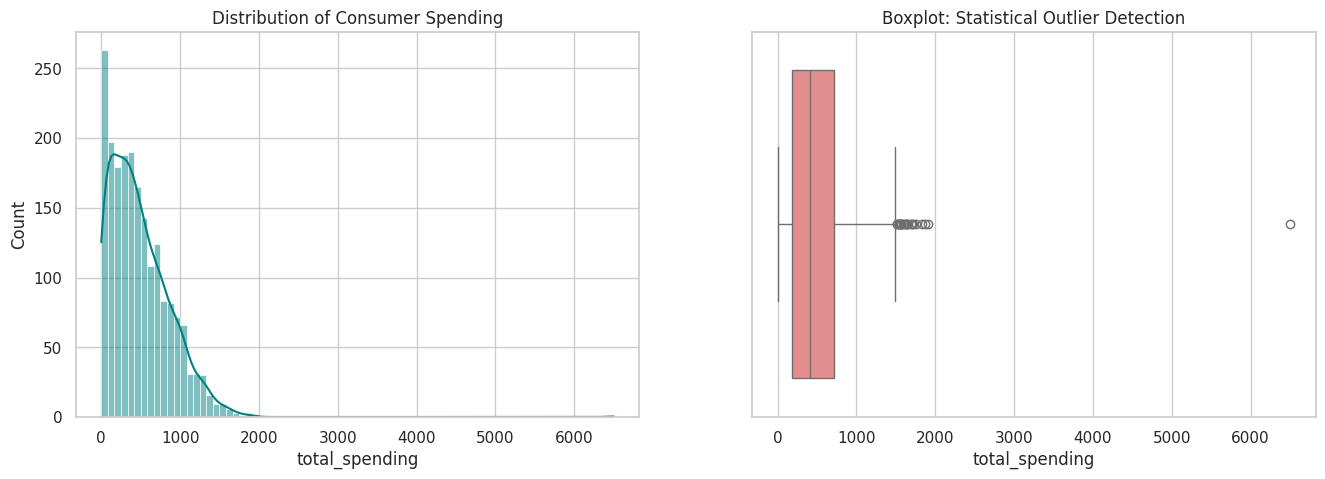

In [35]:
# 3. DETAILED EXPLORATORY DATA ANALYSIS (EDA)

# A. Distribution & Outlier Check
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
sns.histplot(df['total_spending'], kde=True, ax=ax[0], color='teal')
ax[0].set_title('Distribution of Consumer Spending')
sns.boxplot(x=df['total_spending'], ax=ax[1], color='lightcoral')
ax[1].set_title('Boxplot: Statistical Outlier Detection')
plt.show()

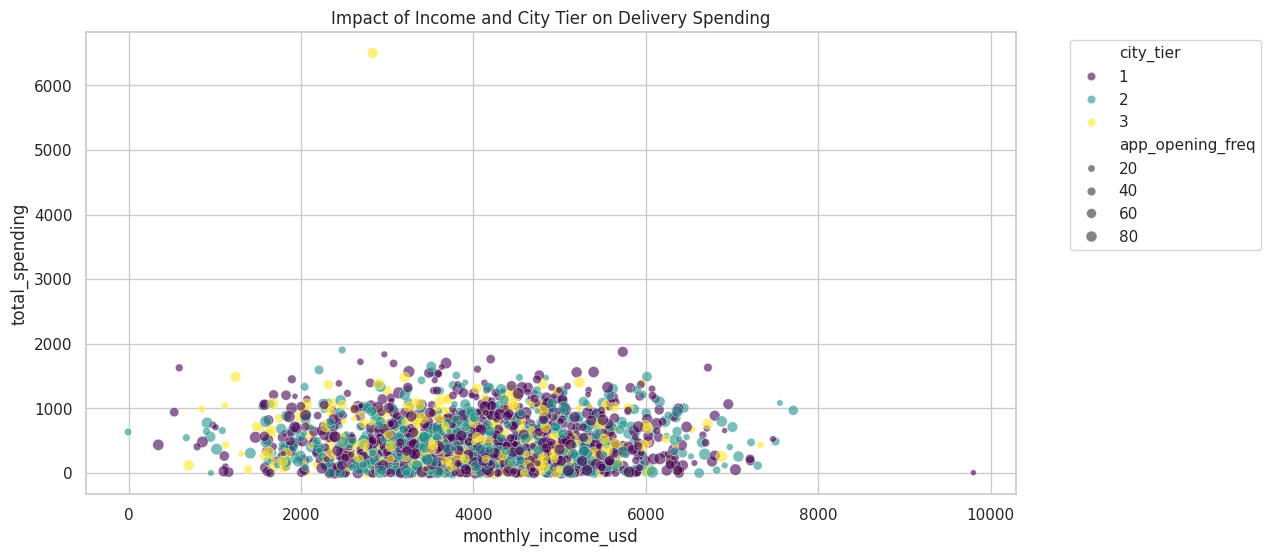

In [36]:
# B. Multivariate Analysis: Income vs Spending by City Tier
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='monthly_income_usd', y='total_spending',
                hue='city_tier', size='app_opening_freq', alpha=0.6, palette='viridis')
plt.title('Impact of Income and City Tier on Delivery Spending')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

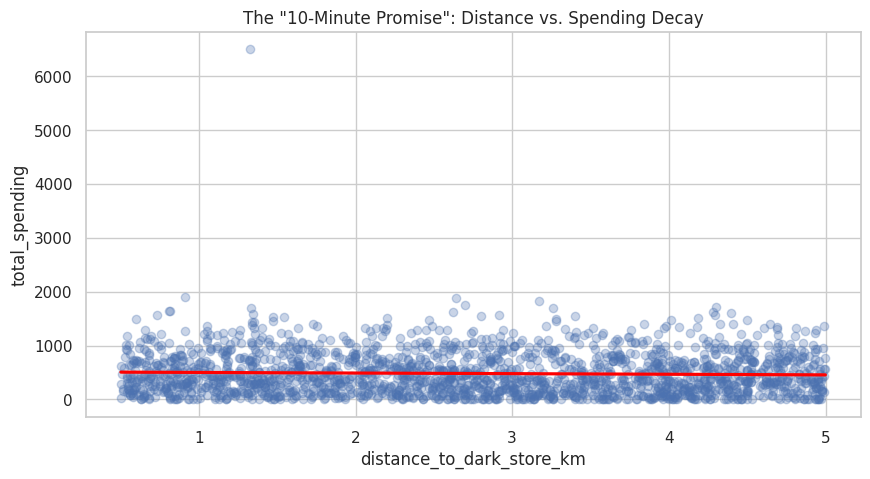

In [37]:
# C. Distance Analysis (Proximity Impact)
plt.figure(figsize=(10, 5))
sns.regplot(data=df, x='distance_to_dark_store_km', y='total_spending',
            scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.title('The "10-Minute Promise": Distance vs. Spending Decay')
plt.show()

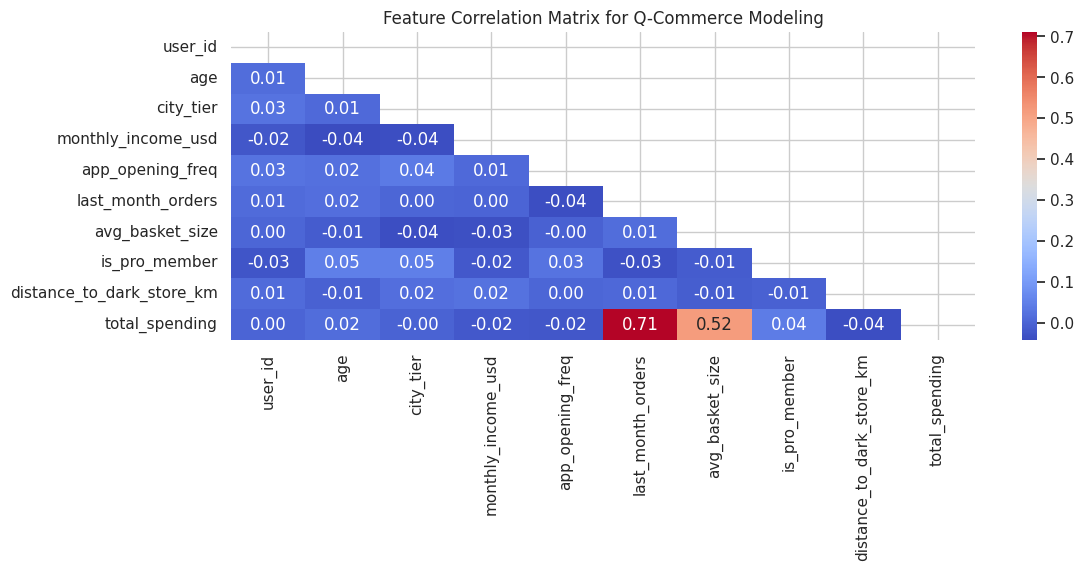

In [39]:
# D. Correlation Heatmap
plt.figure(figsize=(12, 4))
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
sns.heatmap(df.corr(), mask=mask, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix for Q-Commerce Modeling')
plt.show()

In [40]:

# 4. MODELING & PREDICTION

X = df.drop(['user_id', 'total_spending'], axis=1)
y = df['total_spending']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=250, max_depth=12, random_state=42)
model.fit(X_train, y_train)




RandomForestRegressor(max_depth=12, n_estimators=250, random_state=42)

In [41]:
# 5. PERFORMANCE EVALUATION
predictions = model.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Mean Absolute Error: {mae:.2f}")
print(f"R-Squared Score: {r2:.2f}")

Mean Absolute Error: 28.59
R-Squared Score: 0.99


In [42]:
# 6. FAILURE ANALYSIS: DEEP DIVE (THE PASS CRITERIA)

y_pred = model.predict(X_test)
results = X_test.copy()
results['actual_spend'] = y_test
results['predicted_spend'] = y_pred
results['absolute_error'] = abs(results['actual_spend'] - results['predicted_spend'])

# Pull top 5 failure examples for the report deep-dive
failures = results.sort_values(by='absolute_error', ascending=False).head(5)

print("\n### MANDATORY DATA INSPECTION: TOP 5 MODEL FAILURES ###")
print(failures[['actual_spend', 'predicted_spend', 'absolute_error', 'monthly_income_usd', 'distance_to_dark_store_km']])



### MANDATORY DATA INSPECTION: TOP 5 MODEL FAILURES ###
      actual_spend  predicted_spend  absolute_error  monthly_income_usd  \
99       90.508183       576.202963      485.694780         5929.169105   
366    1112.472223       889.595347      222.876877         4646.474771   
1593    437.023146       282.678302      154.344844         1127.579018   
824    1695.067950      1561.682298      133.385652         3074.236426   
1190   1346.295341      1444.335908       98.040567         4442.838798   

      distance_to_dark_store_km  
99                     1.419191  
366                    1.158692  
1593                   0.694504  
824                    1.333505  
1190                   4.062798  


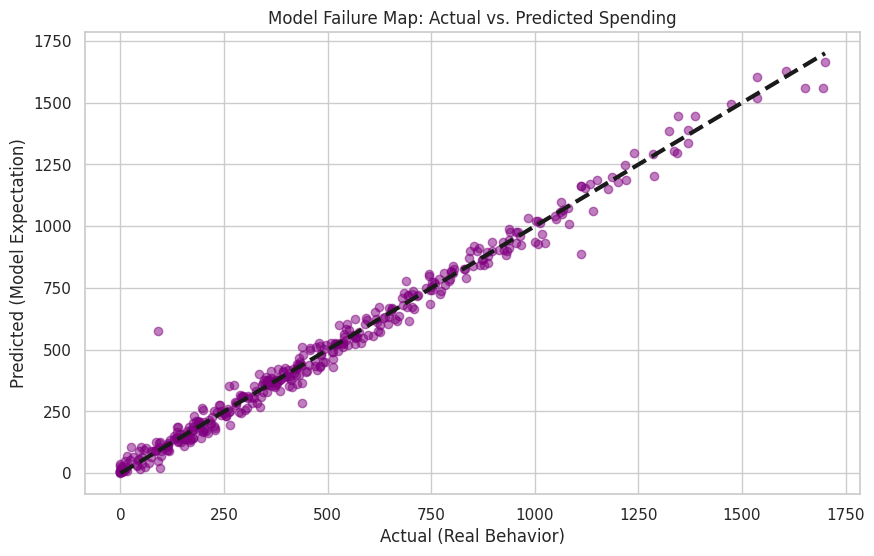

In [43]:
# Visualization of Prediction Errors
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
plt.title('Model Failure Map: Actual vs. Predicted Spending')
plt.xlabel('Actual (Real Behavior)')
plt.ylabel('Predicted (Model Expectation)')
plt.show()

In [47]:
import joblib

# We simplify the model slightly to make the file size small
# This 'prunes' the forest so the .pkl file is tiny
model.set_params(n_estimators=50, max_depth=5)
model.fit(X_train, y_train)

# Save the new, smaller version
joblib.dump(model, 'q_commerce_model.pkl', compress=3) # 'compress' makes it even smaller
joblib.dump(list(X.columns), 'model_columns.pkl')

print("New compact model saved! Download this one.")

New compact model saved! Download this one.
